<a href="https://colab.research.google.com/github/Frans-Grau/ElectricVehicleVsChargingStations/blob/main/Time-Experiments/PySpark-EVPop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=0ad7673309d4509ba699166a16c80ce0411ed47fc281c3898109c82fb8268dae
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
CPU times: user 423 ms, sys: 76.9 ms, total: 500 ms
Wall time: 40.8 s


In [2]:
%%time
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkFiles

CPU times: user 44.7 ms, sys: 5.8 ms, total: 50.5 ms
Wall time: 54.9 ms


In [3]:
%%time
spark = SparkSession.builder.appName("EVPop").getOrCreate()
url = "https://raw.githubusercontent.com/Frans-Grau/ElectricVehicleVsChargingStations/main/Datasets/EVPopulation.csv"
spark.sparkContext.addFile(url)

dfEV = spark.read.csv("file://"+SparkFiles.get("EVPopulation.csv"), header=True, inferSchema= True)

CPU times: user 184 ms, sys: 35.1 ms, total: 220 ms
Wall time: 23.9 s


In [4]:
%%time
dfEV.show()

+----------+-----------+--------------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|     County|          City|State|Postal Code|Model Year|         Make|    Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+-----------+--------------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|WDC0G5EB7K|     Louisa|       Bumpass|   VA|      23024|      2019|MERCEDES-BENZ|GLC-CLASS| Plug-in Hybrid El...|                            

In [5]:
%%time
dfEV.printSchema()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)

CPU times: user 2.13 ms, sys: 905 µs, total: 3.04 ms
Wall time: 12.9 ms


## EDA on the filtered DF -> State = Washington

In [6]:
%%time
### Filter dfEV to just values in WA and save into a new dataframe
df1 = dfEV.filter(dfEV.State == 'WA')

CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 19.7 ms


In [7]:
%%time
### Check for Null values -> the whole df
from pyspark.sql.functions import isnan, when, count, col, isnull
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     0|   0|    0|          0|         0|   0|   84|                    0|                                                0|             0|        0|                   0|             0|              27|             159|                0|


In [8]:
%%time
### Value_counts
dfEV.groupBy('County').count().orderBy('count', ascending=False).show()

+------------+-----+
|      County|count|
+------------+-----+
|        King|60059|
|   Snohomish|12720|
|      Pierce| 8684|
|       Clark| 6834|
|    Thurston| 4207|
|      Kitsap| 3902|
|     Whatcom| 2873|
|     Spokane| 2835|
|      Benton| 1394|
|      Island| 1307|
|      Skagit| 1269|
|     Clallam|  741|
|    San Juan|  729|
|   Jefferson|  701|
|      Chelan|  654|
|      Yakima|  633|
|     Cowlitz|  576|
|       Mason|  555|
|       Lewis|  437|
|Grays Harbor|  398|
+------------+-----+
only showing top 20 rows

CPU times: user 24.6 ms, sys: 1.18 ms, total: 25.8 ms
Wall time: 2.59 s


CPU times: user 69 ms, sys: 4.73 ms, total: 73.7 ms
Wall time: 1.22 s


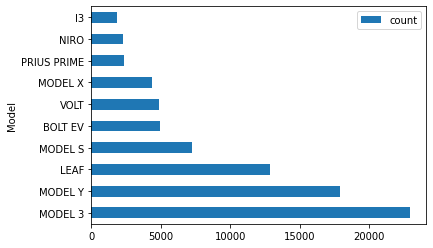

In [11]:
%%time
### CAR MODELS: Value Counts and use paadas to plot
import pandas as pd
models = df1.groupBy('Model').count().orderBy('count', ascending=False)
p_models = models.toPandas()
p_models.set_index('Model', inplace=True)
p_models[:10].plot(kind='barh')